In [29]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

✍ Настало время попрактиковаться в оценке качества моделей.

На этот раз мы окунёмся в онлайн-маркетинг: будем пытаться предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.

Сессия на сайте — это временной интервал, в течение которого происходит взаимодействие пользователя с сайтом. Отсчёт сессии стартует сразу после перехода на сайт и завершается сразу после его закрытия или при отсутствии активных действий в течение некоторого периода времени.

img

Набор данных вы можете скачать по ссылке. С подробным описанием датасета ознакомьтесь в источнике.

Прочитаем таблицу с данными и выведем её на экран, чтобы убедиться, что чтение прошло успешно.

In [30]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.zip')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Посмотрим на размер таблицы:

In [31]:
print(shoppers_data.shape)

## (12330, 18)

(12330, 18)


В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

Заранее удостоверимся в отсутствии пропусков:
В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

Заранее удостоверимся в отсутствии пропусков:


In [32]:
shoppers_data.isna().sum()


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Ни в одном из столбцов пропусков нет.

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():

In [33]:
dummy_data = pd.get_dummies(shoppers_data, dtype=int)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Теперь, когда необходимые преобразования выполнены, мы можем говорить о построении модели.

Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


C:\Users\stepu\AppData\Local\Temp\ipykernel_110580\3825417070.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
C:\Users\stepu\AppData\Local\Temp\ipykernel_110580\3825417070.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
C:\Users\stepu\AppData\Local\Temp\ipykernel_110580\3825417070.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Sess

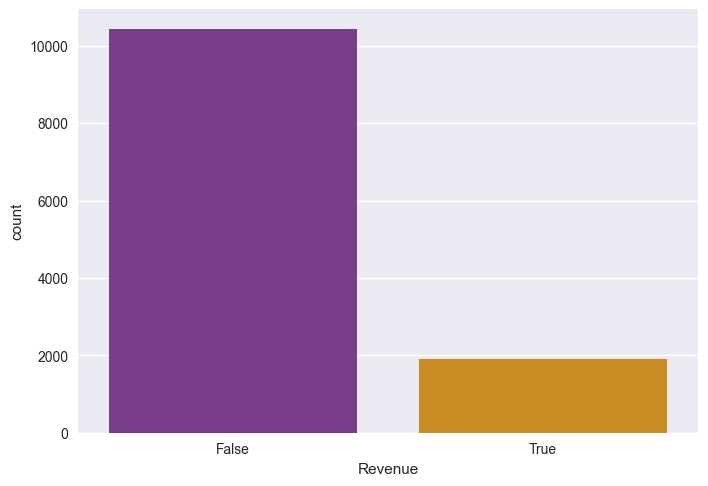

In [34]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Задание 6.1
1/1 point (graded)
Сбалансирована ли, по-вашему, данная выборка?

Нет

верно

Ответ
Верно:Из графика отчётливо видно, что мы имеем дело с несбалансированной выборкой, так как соотношение классов — 85/15, что далеко от сбалансированного соотношения 50/50.

Из 12330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Условимся, что лучшей будет считаться та модель, у которой значение метрики F1 для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [44]:
# Преобразуем Revenue в числовой формат (если не сделать, то будет ошибка - добавлено вручную)
dummy_data['Revenue'] = dummy_data['Revenue'].astype(int)

X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

- Разделим выборку на тренировочную и тестовую.

- Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:

- значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
- значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

### Задание 6.2
2 points possible (graded)
Для начала позаботимся о создании отложенной тестовой выборки.

Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку. В качестве значения параметра random_state возьмите число 42.

Чему равно количество сессий на сайте в тренировочной и тестовой выборках?

Количество сессий в тренировочной выборке:

  9864 
 
Количество сессий в тестовой выборке:

  2466
 

In [46]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)


# Исправление 1: shape это атрибут, а не метод, поэтому не нужны скобки ()
# Исправление 2: для получения количества строк используем [0] или .shape[0]
print(f'Количество сессий на сайте в тренировочной выборке: {y_train.shape[0]}')
print(f'Количество сессий на сайте в тестовой выборке: {y_valid.shape[0]}')

print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Количество сессий на сайте в тренировочной выборке: 9864
Количество сессий на сайте в тестовой выборке: 2466
Train:
Revenue
0    0.845296
1    0.154704
Name: proportion, dtype: float64
Valid:
Revenue
0    0.845093
1    0.154907
Name: proportion, dtype: float64


### Задание 6.3
2 points possible (graded)

Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — F1-score.

Чему равно среднее значение метрики F1 на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

Средняя F1-score на тренировочных фолдах:

1,0  
 
Средняя  F1 -score на валидационных фолдах:

0,65    (мой результат и результат эталонного решения дают значение 0,635=0,64 - вероятно в проверке есть ошибка)
 

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Создаем модель
rf_model = RandomForestClassifier(random_state=42)

# Создаем кросс-валидатор
skf = StratifiedKFold(n_splits=5) #, shuffle=False)

# Проводим кросс-валидацию с подсчетом метрик на тренировочном и тестовом наборах
cv_results = cross_validate(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1',
    return_train_score=True  # важный параметр для получения тренировочных метрик
)

# Выводим средние значения F1 для обоих наборов
train_f1 = cv_results['train_score'].mean()
val_f1 = cv_results['test_score'].mean()

print(f'Среднее значение F1 на тренировочных фолдах: {train_f1:.2f}')
print(f'Среднее значение F1 на валидационных фолдах: {val_f1:.4f}')


print('Train k-fold mean f1: {:.3f}'.format(np.mean(cv_results['train_score']))) 
print('Valid k-fold mean f1: {:.3f}'.format(np.mean(cv_results['test_score']))) 

Среднее значение F1 на тренировочных фолдах: 1.00
Среднее значение F1 на валидационных фолдах: 0.6350
Train k-fold mean f1: 1.000
Valid k-fold mean f1: 0.635


### Задание 6.4
1/1 point (graded)
Является ли, по-вашему, построенная в предыдущем задании модель случайного леса переобученной?

Да

Ответ

Верно:Так как среднее значение  F1 -score на валидационных фолдах значительно ниже, чем на тренировочных, можно с уверенностью сказать, что модель является переобученной.

### Задание 6.5
1 point possible (graded)

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

Случайный лес из деревьев максимальной глубины 5.
Случайный лес из деревьев максимальной глубины 7.
Случайный лес из деревьев максимальной глубины 12.

Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

Совет: воспользуйтесь функцией plot_learning_curve(), которую мы создали в юните по кривым обучения.

Для построения кривых используйте обучающий набор данных (X_train, y_train), стратифицированный кросс-валидатор на пяти фолдах (StratifiedKFold) и метрику  F1 -score. Остальные параметры функции learning_curve() оставьте по умолчанию.

Из построенных кривых обучения сделайте вывод: какая глубина деревьев в лесу является оптимальной?

Ответ

(max_depth = 7)


In [48]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

In [49]:
#Создаём список из моделей
models = [
    RandomForestClassifier(
        #criterion='entropy', #критерий информативности
        max_depth=5, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        n_estimators = 200
        #class_weight='balanced' #веса классов
    ),
    RandomForestClassifier(
        #criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        n_estimators = 200
        #class_weight='balanced' #веса классов
    ),
    RandomForestClassifier(
        #criterion='entropy', #критерий информативности
        max_depth=12, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        n_estimators = 200
        #class_weight='balanced' #веса классов
    )
]

c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
        estimator, response_method.__name__, X, pos_label=pos_label
    )
  File "c:\Users\stepu\OneDrive\IDE\.venv313\Lib\site-packages

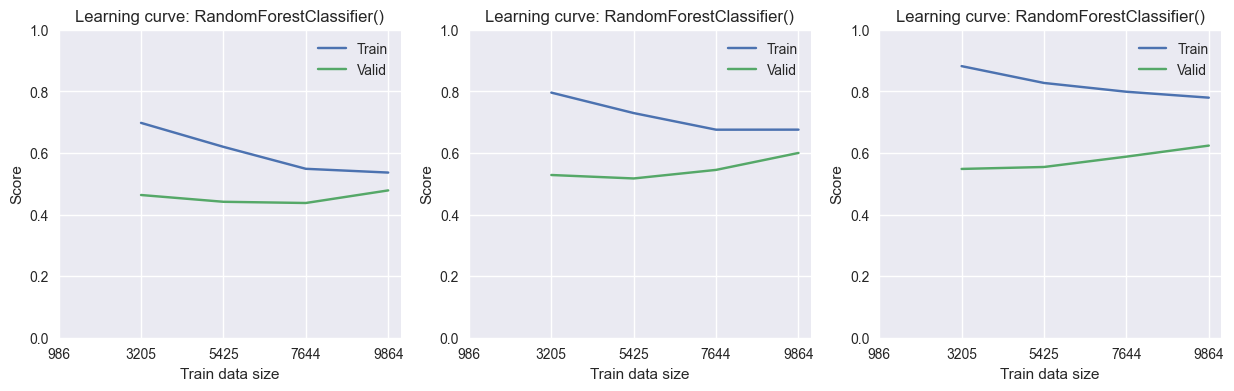

In [50]:
#Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

### Задание 6.6

4 points possible (graded)

Обучите случайный лес с выбранной в предыдущем задании оптимальной глубиной на тренировочной выборке. Сделайте предсказание меток классов и выведите отчёт о метриках классификации.

Ответьте на следующие вопросы:

1. Чему равно значение метрики accuracy? Ответ округлите до двух знаков после точки-разделителя.

Accuracy:

  0.91 (в ответе 0.90)
 
2. Чему равно значение метрики F1 для посетителей, завершивших сессию без покупки товара? Ответ округлите до двух знаков после точки-разделителя.

F1 для класса False:

  0.95 (в ответе 0.94)
 
3. Чему равно значение метрики F1 для посетителей, купивших товар во время сессии? Ответ округлите до двух знаков после точки-разделителя.

F1 для класса True:

  0.62 (в ответе 0.60)
 
Какой вывод можно сделать?

In [55]:
model_rf7 = RandomForestClassifier(
        #criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        n_estimators = 200
        #class_weight='balanced' #веса классов
    )

model_rf7.fit(X_train, y_train)
y_pred = model_rf7.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))
print(metrics.accuracy_score(y_valid, y_pred))
print(metrics.f1_score(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2084
           1       0.82      0.50      0.62       382

    accuracy                           0.91      2466
   macro avg       0.87      0.74      0.78      2466
weighted avg       0.90      0.91      0.90      2466

0.9055150040551501
0.6223662884927067


In [54]:
# Эталонное решение (результаты такие же, в проверке есть ошибка)

model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)
y_test_predict = model.predict(X_valid)
print(metrics.classification_report(y_valid, y_test_predict))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2084
           1       0.82      0.50      0.62       382

    accuracy                           0.91      2466
   macro avg       0.87      0.74      0.78      2466
weighted avg       0.90      0.91      0.90      2466





               precision    recall  f1-score   support

           0       0.91      0.98      0.94      2084
           1       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



### Задание 6.7

1 point possible (graded)

Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.

Порог вероятности будем подбирать с помощью кросс-валидации.

Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах. Используйте метод cross_val_predict().

Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 оптимальной максимальной глубиной деревьев, набор данных (параметры X, y) — тренировочная выборка (X_train, y_train).

Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики  F1  для посетителей, которые совершат покупку. Определите порог вероятности, соответствующий этой точке.

В качестве ответа приведите значение выбранного порога вероятности. Ответ округлите до двух знаков после точки-разделителя.

0.36 (в моем решении 0.33)


Best threshold = 0.326, F1-Score = 0.68


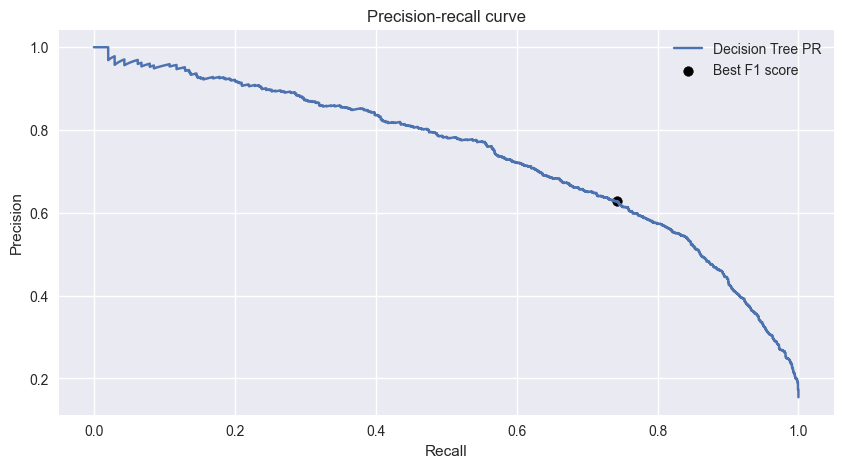

In [57]:
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model_rf7, X_train, y_train, cv=skf, method='predict_proba')
#Строим PR-кривую
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred[:, 1])

#Строим PR-кривую
#plt.figure(figsize=(10, 5))


# print('Thresholds:', thresholds[:5])
# print('Precision scores:', precision[:5])
# print('Recall scores:',recall[:5])

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.3f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

### Задание 6.8

4 points possible (graded)

Сделайте предсказание классов объекта с определённым в предыдущем задании порогом вероятности. Выведите отчёт о метриках классификации.

Ответьте на следующие вопросы:

1. Чему равно значение метрики accuracy? Ответ округлите до двух знаков после точки-разделителя.

Accuracy:

0.90  
 
2. Чему равно значение метрики F1 для посетителей, завершивших сессию без покупки товара? Ответ округлите до двух знаков после точки-разделителя.

F1 для класса False:

0.94   
 
3. Чему равно значение метрики  F1  для посетителей, купивших товар во время сессии? Ответ округлите до двух знаков после точки-разделителя.

F1  для класса True:

0.67 (у меня 0.70)

   
 

In [61]:
#Задаём оптимальный порог вероятностей

threshold_opt = thresholds[idx]
threshold_opt = 0.36

y_valid_pred_proba = model_rf7.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2084
           1       0.68      0.72      0.70       382

    accuracy                           0.90      2466
   macro avg       0.82      0.83      0.82      2466
weighted avg       0.91      0.90      0.91      2466

